### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'

print "Data Direc"
print data_dir

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
print "File Name"
print filename
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
print filename

df=sqlContext.read.parquet(filename)
print df.count()
df.show(100)

Populating the interactive namespace from numpy and matplotlib
Data Direc
../../Data/Weather
File Name
../../Data/Weather/STAT_SSSBBBBB.pickle
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
../../Data/Weather/US_Weather_SSSBBBBB.parquet
12886
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TOBS|USC00058212|     2|[40 D6 28 D8 E0 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0

In [ ]:
sqlContext.registerDataFrameAsTable(df,'testSNWD')
Query = "SELECT DISTINCT station FROM testSNWD"
print Query
dfSNWDNames = sqlContext.sql(Query)
print dfSNWDNames.count(),'rows'
dfSNWDNames.show(100)
rows=dfSNWDNames.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TSNWDTest=np.vstack(rows)
shape(TSNWDTest)

### Select data for a particular station and measurement type

In [7]:
sqlContext.registerDataFrameAsTable(df,'weather2')
Query="SELECT * FROM weather2\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00058212')
print Query
dfSnow = sqlContext.sql(Query)
print dfSnow.count(),'rows'
dfSnow.show(20)
rows=dfSnow.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TSnow=np.vstack(rows)
#TSNOW=T/10.  # scaling to make the temperature be in centingrates
shape(TSnow)

#To obtain correlation between SNWD and TOBS for year 1952 
sqlContext.registerDataFrameAsTable(dfSnow,'weatherIn1952')
Query = "SELECT vector from weatherIn1952 WHERE year=1952"
print Query
dfSnowCorrelation = sqlContext.sql(Query)
print dfSnowCorrelation.count(),'rows'
dfSnowCorrelation.show(10)
rows=dfSnowCorrelation.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TSNWD = np.vstack(rows)
shape(TSNWD)


SELECT * FROM weather2
	WHERE measurement='SNWD' and station='USC00058212'
4 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[5E 60 90 60 C4 6...|1949.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     1|[28 5B F0 5B 5C 5...|1950.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[5C 61 5C 61 8E 6...|1951.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[75 65 75 65 5C 6...|1952.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+

SELECT vector from weatherIn1952 WHERE year=1952
1 rows
+--------------------+
|              vector|
+--------------------+


(1, 365)

In [8]:
#To obtain correlation between SNWD and TOBS for year 1952
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00058212')
print Query
dfTOBS = sqlContext.sql(Query)
print dfTOBS.count(),'rows'
dfTOBS.show(20)
rows=dfTOBS.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TTobs=np.vstack(rows)
TTobs=TTobs/10.  # scaling to make the temperature be in centingrates
shape(TTobs)

SELECT vector FROM weather
	WHERE measurement='TOBS' and station='USC00058212'
1 rows
+--------------------+
|              vector|
+--------------------+
|[40 D6 28 D8 E0 D...|
+--------------------+



(1, 365)

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather3')
Query="SELECT * FROM weather3\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00058212')
print Query
dfPRCP1 = sqlContext.sql(Query)
print dfPRCP1.count(),'rows'
dfPRCP1.show(20)
rows=dfPRCP1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TPRCP=np.vstack(rows)
#TPRCP=TTobs/10.  # scaling to make the temperature be in centingrates
shape(TPRCP)

#To obtain coorelation between PRCP and TSOB, SNWD for the year 1952 as all of them have a common entry there

#To obtain correlation between SNWD and TOBS for year 1952 
sqlContext.registerDataFrameAsTable(dfPRCP1,'weather1952')
Query = "SELECT vector from weather1952 WHERE year=1952"
print Query
dfPRCP = sqlContext.sql(Query)
print dfPRCP.count(),'rows'
dfPRCP.show(10)
rows=dfPRCP.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TPrcp = np.vstack(rows)
print shape(TPrcp)

SELECT * FROM weather3
	WHERE measurement='PRCP' and station='USC00058212'
6 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|    15|[00 00 00 00 40 4...|1900.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     2|[00 00 00 00 20 5...|1948.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     0|[00 00 C0 50 80 4...|1949.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     0|[00 00 80 4F 00 4...|1950.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     0|[20 54 00 00 C0 4...|1951.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     0|[00 00 00 00 00 0...|1952.0|SSSBBBBB|
+---------+--------+-------

In [10]:
def plotScatter(x,y):
    matplotlib.pyplot.scatter(x,y)
    matplotlib.pyplot.show()

(365, 2)
          a         b
a  1.000000 -0.692974
b -0.692974  1.000000


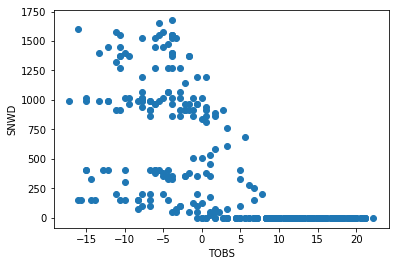

In [11]:
## To determine Coorelation between TOBS and SNWD

import scipy
plt.scatter(TTobs,TSNWD)
plt.xlabel("TOBS")
plt.ylabel("SNWD")
#plt.title("Coorelation Plot between TOBS and SNWD")
#scipy.stats.pearsonr(TTobsCorrelation[0][:], TSnowCorrelation[0][:])
df = pd.DataFrame({'a': TTobs[0][:], 'b': TSNWD[0][:]})
print df.shape
print df.corr()

(365, 2)
          a         b
a  1.000000 -0.137492
b -0.137492  1.000000


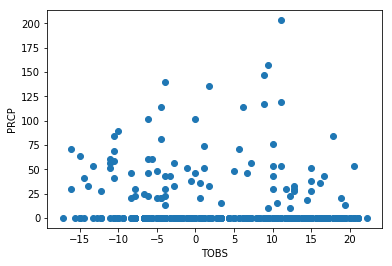

In [12]:
## To determine Coorelation between TOBS and PRCP
plt.scatter(TTobs,TPrcp)
plt.xlabel("TOBS")
plt.ylabel("PRCP")
#plt.title("Coorelation Plot between TOBS and PRCP for USC00058212 in a particular year(1952)")
#scipy.stats.pearsonr(TTobsCorrelation[0][:], TSnowCorrelation[0][:])
df = pd.DataFrame({'a': TTobs[0][:], 'b': TPrcp[0][:]})
print df.shape
print df.corr()

(365, 2)
          a         b
a  1.000000  0.086116
b  0.086116  1.000000


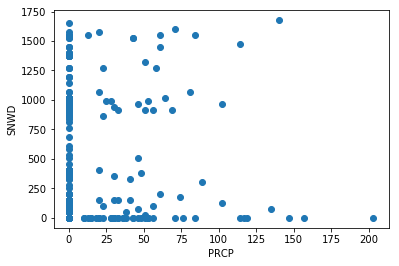

In [13]:
## To determine Coorelation between PRCP and SNWD
plt.scatter(TPrcp,TSNWD)
plt.xlabel("PRCP")
plt.ylabel("SNWD")
#plt.title("Coorelation Plot between PRCP and SNWD for USC00058212 in a particular year(1952)")
#scipy.stats.pearsonr(TTobsCorrelation[0][:], TSnowCorrelation[0][:])
df = pd.DataFrame({'a': TPrcp[0][:], 'b': TSNWD[0][:]})
print df.shape
print df.corr()

### Script for plotting yearly plots

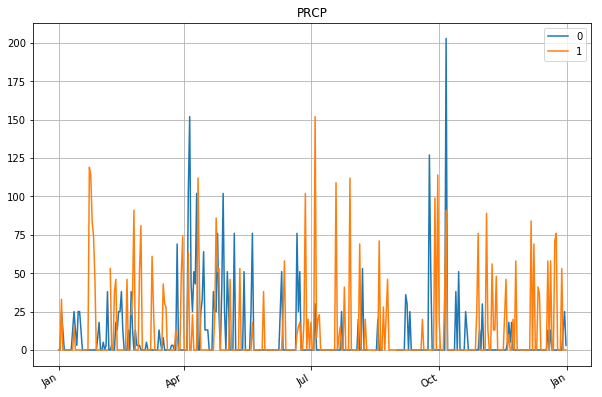

In [14]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(TPRCP[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [15]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


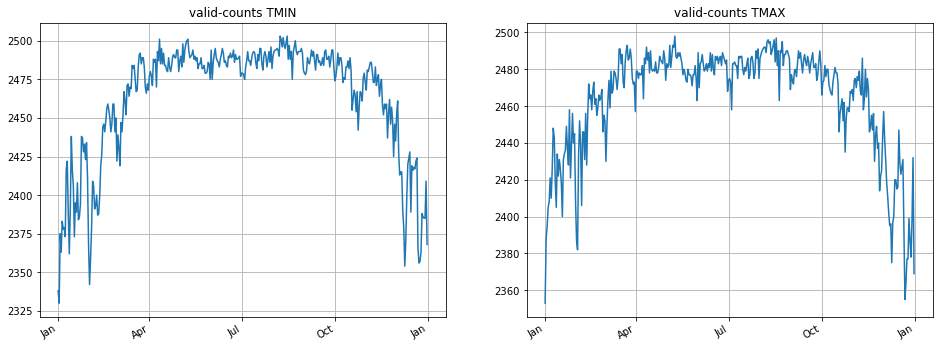

In [16]:
plot_pair(['TMIN','TMAX'],plot_valid)

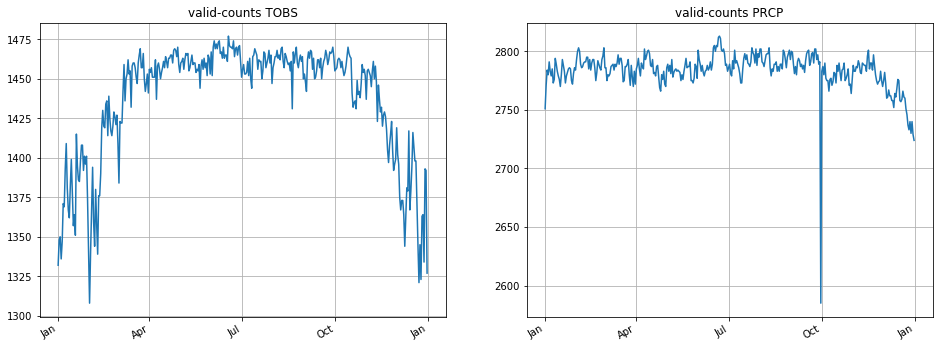

In [17]:
plot_pair(['TOBS','PRCP'],plot_valid)

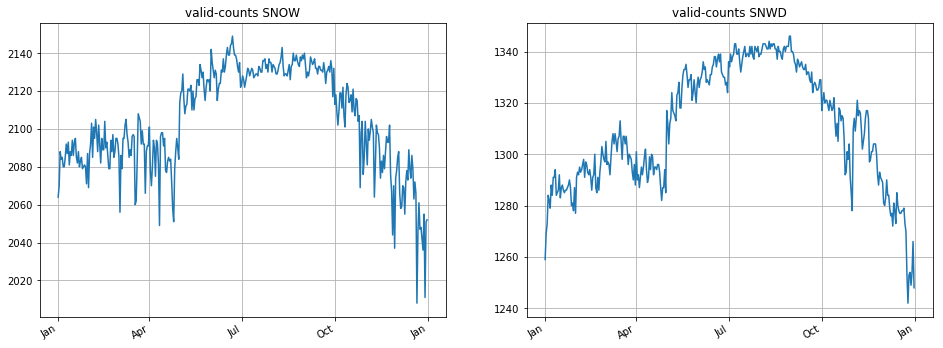

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [19]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean/10-std/10,mean/10,mean/10+std/10]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

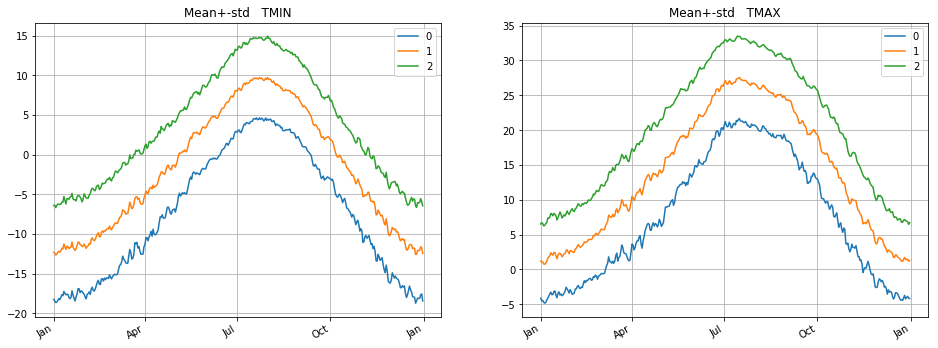

In [20]:
plot_pair(['TMIN','TMAX'],plot_mean_std)


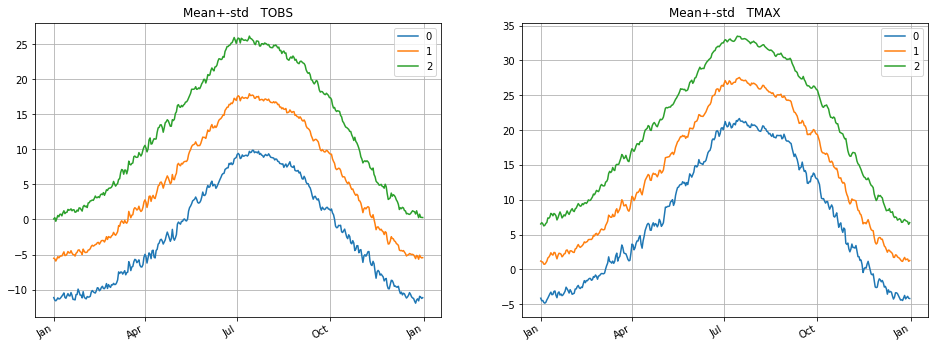

In [21]:
plot_pair(['TOBS','TMAX'],plot_mean_std)

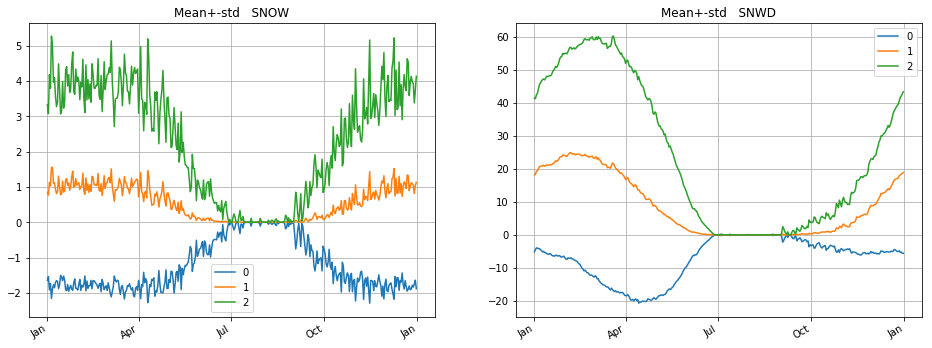

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [23]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

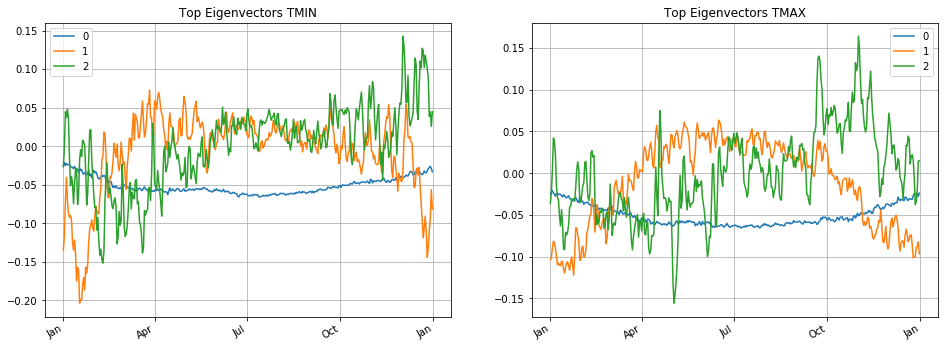

In [24]:
plot_pair(['TMIN','TMAX'],plot_eigen)

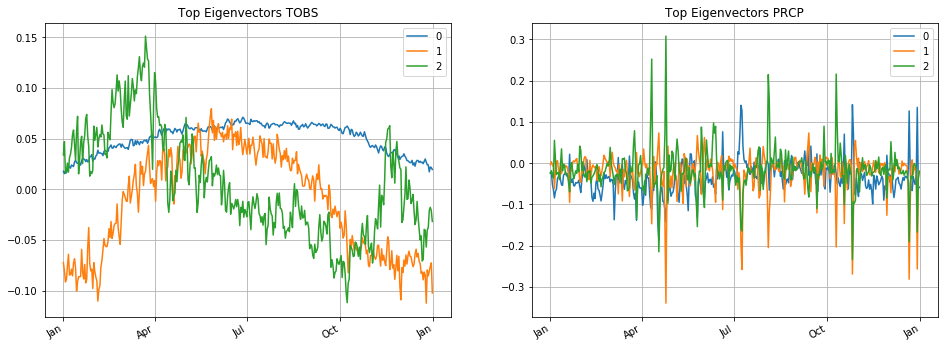

In [25]:
plot_pair(['TOBS','PRCP'],plot_eigen)

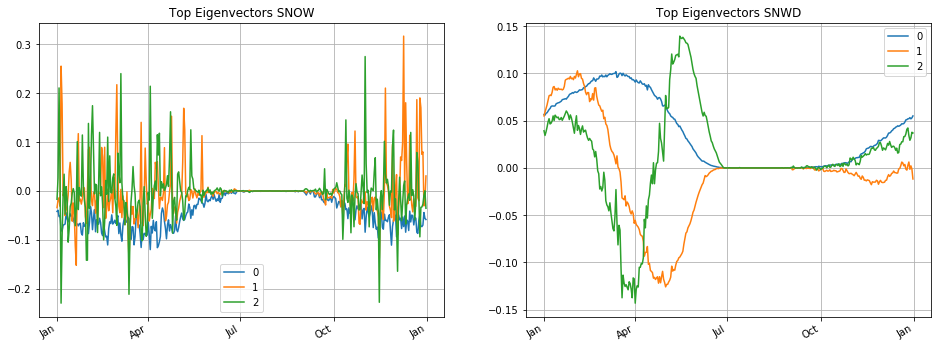

In [26]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [27]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

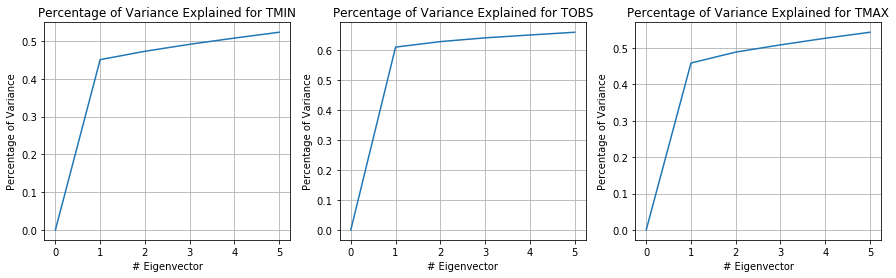

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

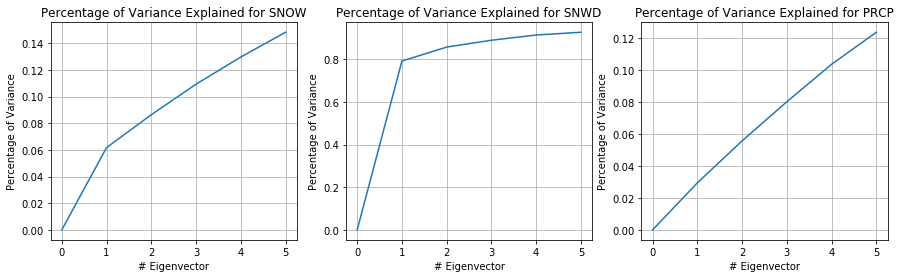

In [29]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [30]:
sc.stop()